<a href="https://colab.research.google.com/github/deepu-san/Projects/blob/main/Chennai%20House%20Price%20Prediction/Chennai_House_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Real estate transactions are quite opaque sometimes and it may be difficult for a newbie to know the fair price of any given home. Thus, multiple real estate websites have the functionality to predict the prices of houses given different features regarding it. Such forecasting models will help buyers to identify a fair price for the home and also give insights to sellers as to how to build homes that fetch them more money. Chennai house sale price data is shared here and the participants are expected to build a sale price prediction model that will aid the customers to find a fair price for their homes and also help the sellers understand what factors are fetching more money for the houses?

 Also, it will be better to give a forecast range (range of permissible values) rather than a single estimate as it will help the customers to negotiate.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from scipy import stats


Loading the CSV file

In [2]:
path="https://raw.githubusercontent.com/deepu-san/Projects/main/Chennai%20House%20Price%20Prediction/train-chennai-sale.csv"
df = pd.read_csv(path)
df.head(3)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,...,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,...,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,...,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200


# Data Cleaning

In [3]:
df[df.duplicated()]

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,...,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE


Here we checked if there were any duplicate data points. Since it returned an empty data frame, we can conclude that there are no duplicates in the data.

Now we have to check the data types of the features.


In [4]:
df.dtypes

PRT_ID            object
AREA              object
INT_SQFT           int64
DATE_SALE         object
DIST_MAINROAD      int64
N_BEDROOM        float64
N_BATHROOM       float64
N_ROOM             int64
SALE_COND         object
PARK_FACIL        object
DATE_BUILD        object
BUILDTYPE         object
UTILITY_AVAIL     object
STREET            object
MZZONE            object
QS_ROOMS         float64
QS_BATHROOM      float64
QS_BEDROOM       float64
QS_OVERALL       float64
REG_FEE            int64
COMMIS             int64
SALES_PRICE        int64
dtype: object

Here as we can see  'DATE_SALE' and 'DATE_BUILD' are present as string/objects. We are going to convert them to date-time objects and then create another feature called 'AGE', which might be a influential feature. 

In [5]:
df['DATE_SALE'] = pd.to_datetime(df['DATE_SALE'],format='%d-%m-%Y', errors='coerce')
df['DATE_BUILD'] = pd.to_datetime(df['DATE_BUILD'],format='%d-%m-%Y', errors='coerce')
df["AGE"]=(df["DATE_SALE"]-df["DATE_BUILD"])/np.timedelta64(1, 'Y') #gives us the AGE in temrs of years

df["AGE"]=df["AGE"].apply(np.floor)
df["AGE"]=df["AGE"].astype("int")

Next we convert 'N_BEDROOM' and 'N_BATHROOM' to 'int' datatypes which are given as 'float' datatypes.

In [6]:
df['N_BEDROOM']=df['N_BEDROOM'].astype('Int64')
df['N_BATHROOM']=df['N_BATHROOM'].astype('Int64')

Now we can drop unwanted featues from the dataframe.

In [7]:
df.drop(["DATE_SALE","DATE_BUILD","PRT_ID","REG_FEE","COMMIS","QS_ROOMS","QS_BATHROOM","QS_BEDROOM","QS_OVERALL"],axis=1,inplace=True)


Next we have to check if there are any null/Nan values in the dataframe and then deal with it.

In [8]:
df.isna().sum()

AREA             0
INT_SQFT         0
DIST_MAINROAD    0
N_BEDROOM        1
N_BATHROOM       5
N_ROOM           0
SALE_COND        0
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
MZZONE           0
SALES_PRICE      0
AGE              0
dtype: int64

In [9]:
df.corr()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALES_PRICE,AGE
INT_SQFT,1.000000,0.002022,0.786348,0.515390,0.951279,0.612125,-0.012776
DIST_MAINROAD,0.002022,1.000000,-0.002566,0.001970,0.002301,0.018783,-0.003588
N_BEDROOM,0.786348,-0.002566,1.000000,0.755214,0.840286,0.330999,-0.045950
N_BATHROOM,0.515390,0.001970,0.755214,1.000000,0.568688,0.108884,-0.020130
N_ROOM,0.951279,0.002301,0.840286,0.568688,1.000000,0.602760,-0.033448
SALES_PRICE,0.612125,0.018783,0.330999,0.108884,0.602760,1.000000,-0.119037
AGE,-0.012776,-0.003588,-0.045950,-0.020130,-0.033448,-0.119037,1.000000


From the correlation data we can see that 'N_BEDROOM' and 'N_BATHROOM' have good correlation with the feature 'N_ROOM', hence we can try to fill the null values using this information.

In [10]:
df['N_BEDROOM'] = df.groupby('N_ROOM')['N_BEDROOM'].apply(lambda x:x.fillna(x.mode()[0]))
df['N_BATHROOM'] = df.groupby('N_ROOM')['N_BATHROOM'].apply(lambda x:x.fillna(x.mode()[0]))

In the case of null value in the feature 'N_BEDROOM', we first look at the 'N_ROOM' feature (which is the number of rooms). Then we take the mode value of 'N_BEDROOM' with that specific number of rooms, 'N_ROOMS'and then use this value to fill the nan/null values. This was also done for missing values in 'N_BATHROOM'.

In [11]:
df['N_BEDROOM']=df['N_BEDROOM'].astype('int64')
df['N_BATHROOM']=df['N_BATHROOM'].astype('int64')

In [12]:
df.isna().sum()

AREA             0
INT_SQFT         0
DIST_MAINROAD    0
N_BEDROOM        0
N_BATHROOM       0
N_ROOM           0
SALE_COND        0
PARK_FACIL       0
BUILDTYPE        0
UTILITY_AVAIL    0
STREET           0
MZZONE           0
SALES_PRICE      0
AGE              0
dtype: int64

Corercting Spelling Mistakes in Data


In [13]:
df['AREA'].unique()

array(['Karapakkam', 'Anna Nagar', 'Adyar', 'Velachery', 'Chrompet',
       'KK Nagar', 'TNagar', 'T Nagar', 'Chrompt', 'Chrmpet', 'Karapakam',
       'Ana Nagar', 'Chormpet', 'Adyr', 'Velchery', 'Ann Nagar',
       'KKNagar'], dtype=object)

In [14]:
df["AREA"] = df["AREA"].replace({"Chrompt" : "Chrompet", "Chrmpet" : "Chrompet","Chormpet":"Chrompet","TNagar":"T Nagar","Karapakam":"Karapakkam",
                                "Ana Nagar":"Anna Nagar","Velchery":"Velachery","Ann Nagar":"Anna Nagar","Adyr":"Adyar","KKNagar":"KK Nagar"})

In [15]:
df['SALE_COND'].unique()

array(['AbNormal', 'Family', 'Partial', 'AdjLand', 'Normal Sale',
       'Ab Normal', 'Partiall', 'Adj Land', 'PartiaLl'], dtype=object)

In [16]:
df["SALE_COND"] = df["SALE_COND"].replace({"Adj Land" : "AdjLand", "Ab Normal" : "AbNormal","Partiall":"Partial","PartiaLl":"Partial"})

In [17]:
df['PARK_FACIL'].unique()

array(['Yes', 'No', 'Noo'], dtype=object)

In [18]:
df["PARK_FACIL"] = df["PARK_FACIL"].replace({"Noo" : "No"})


In [19]:
df["BUILDTYPE"].unique()

array(['Commercial', 'Others', 'Other', 'House', 'Comercial'],
      dtype=object)

In [20]:
df["BUILDTYPE"] = df["BUILDTYPE"].replace({"Other" : "Others","Comercial":"Commercial"})


In [21]:
df['UTILITY_AVAIL'].unique()

array(['AllPub', 'ELO', 'NoSewr ', 'NoSeWa', 'All Pub'], dtype=object)

In [22]:
df["UTILITY_AVAIL"] = df["UTILITY_AVAIL"].replace({"NoSewr " : "NoSewr","All Pub":"AllPub"})

In [23]:
df['STREET'].unique()

array(['Paved', 'Gravel', 'No Access', 'Pavd', 'NoAccess'], dtype=object)

In [24]:
df["STREET"] = df["STREET"].replace({"Pavd" : "Paved","NoAccess":"No Access"})


In [25]:
df['MZZONE'].unique()

array(['A', 'RH', 'RL', 'I', 'C', 'RM'], dtype=object)

In [ ]:
# df["SALE_COND"] = df["SALE_COND"].replace({"Adj Land" : "AdjLand", "Ab Normal" : "AbNormal","Partiall":"Partial","PartiaLl":"Partial"})

# df["PARK_FACIL"] = df["PARK_FACIL"].replace({"Noo" : "No"})

# df["BUILDTYPE"] = df["BUILDTYPE"].replace({"Other" : "Others","Comercial":"Commercial"})

# df["UTILITY_AVAIL"] = df["UTILITY_AVAIL"].replace({"NoSewr " : "NoSewr","All Pub":"AllPub"})

# df["STREET"] = df["STREET"].replace({"Pavd" : "Paved","NoAccess":"No Access"})


Next we have to check if outliers are present in the data.

In [26]:
df.describe()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALES_PRICE,AGE
count,7109.000000,7109.000000,7109.000000,7109.000000,7109.000000,7.109000e+03,7109.000000
mean,1382.073006,99.603179,1.637080,1.213251,3.688704,1.089491e+07,23.291743
std,457.410902,57.403110,0.802857,0.409632,1.019099,3.768603e+06,12.342006
min,500.000000,0.000000,1.000000,1.000000,2.000000,2.156875e+06,3.000000
25%,993.000000,50.000000,1.000000,1.000000,3.000000,8.272100e+06,13.000000
50%,1373.000000,99.000000,1.000000,1.000000,4.000000,1.033505e+07,22.000000
75%,1744.000000,148.000000,2.000000,1.000000,4.000000,1.299390e+07,33.000000
max,2500.000000,200.000000,4.000000,2.000000,6.000000,2.366734e+07,54.000000


From this we can see that the data does not contain any significant outliers

---



# EDA 

Distribution plots for numerical features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


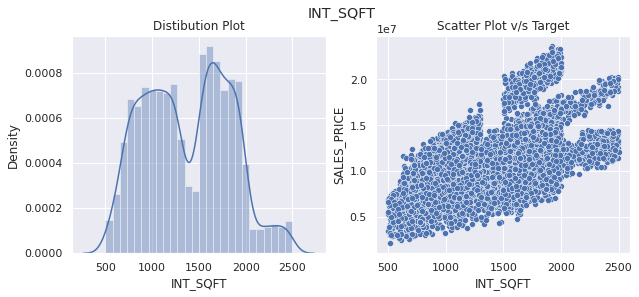

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('INT_SQFT')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["INT_SQFT"],ax=axes[0])
sns.scatterplot(data=df, x="INT_SQFT", y="SALES_PRICE")



*   Here we can clearly see a linear relationship between 'INT_SQFT' and Average Sales Price.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


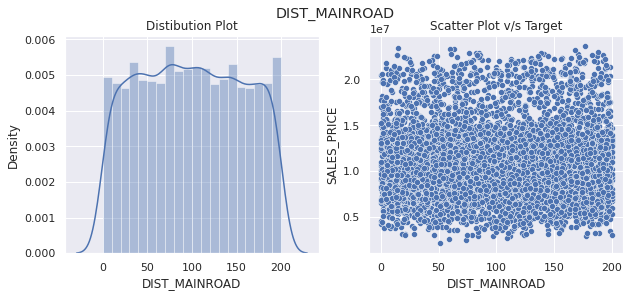

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('DIST_MAINROAD')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Scatter Plot v/s Target')

sns.distplot( df["DIST_MAINROAD"],ax=axes[0])
sns.scatterplot(data=df, x="DIST_MAINROAD", y="SALES_PRICE")


Here we don't see any linear relationship between  'DIST_MAINROAD' and target which is 'SALES_PRICE'. The feature was also transformed to check if any non-linear relationship existed. But none was found. Hence we can drop this feature. 

In [ ]:
df.drop('DIST_MAINROAD',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Avg Sales Price')

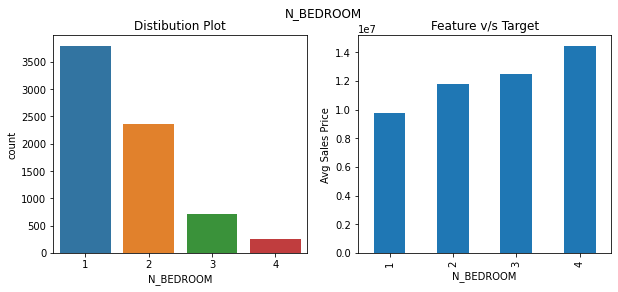

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_BEDROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Feature v/s Target')

sns.countplot( df["N_BEDROOM"],ax=axes[0])
ax=df.groupby("N_BEDROOM")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Avg Sales Price")



*   In the second graph which shows Average Sales Price against the No.of Bedrooms in a property we can see a clear linear relationship.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Avg Sales Price')

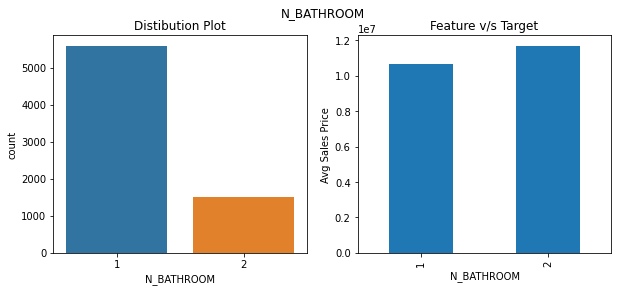

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_BATHROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Feature v/s Target')

sns.countplot( df["N_BATHROOM"],ax=axes[0])
ax=df.groupby("N_BATHROOM")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Avg Sales Price")


*   The No. of properties with 1 bathroom are almost four times as those with 2 bathrooms 
*   Here also from the second graph we can see a linear relationship betwwen No.of Bathroom and Average Sales Price.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Avg Sales Price')

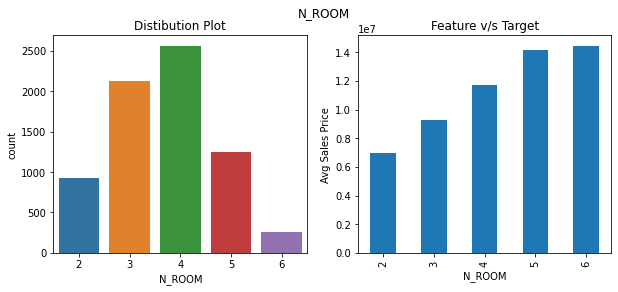

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('N_ROOM')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Feature v/s Target')

sns.countplot( df["N_ROOM"],ax=axes[0])
ax=df.groupby("N_ROOM")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Avg Sales Price")



*   In the first graph we can see that properties with total 4 rooms have been sold the most, with the count decreasing to both sides.
*   In the second graph we see a linear relationship between Average Sales Price and Number of rooms.



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Age')

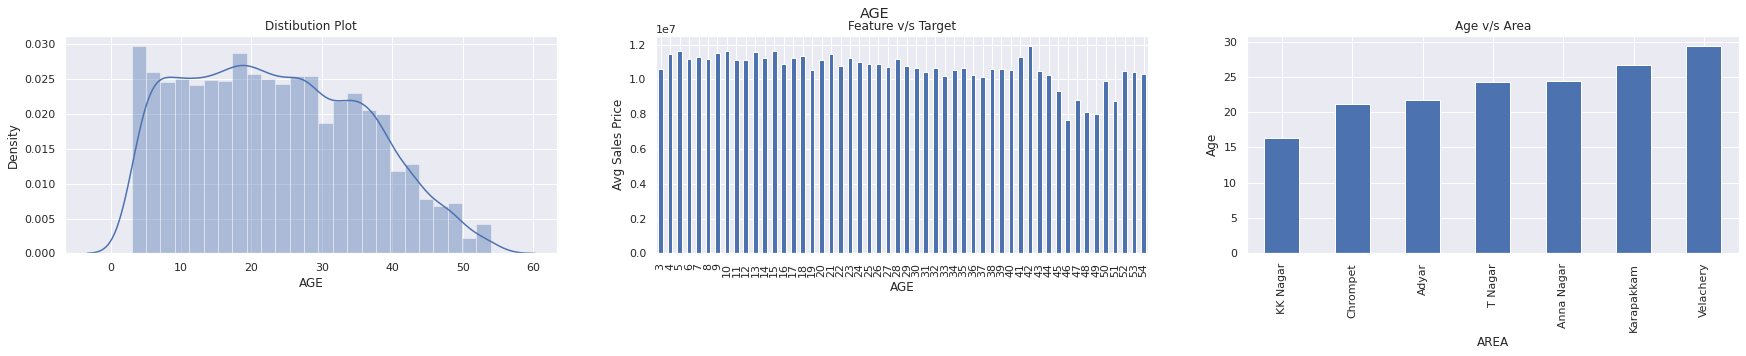

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,4))
fig.suptitle('AGE')

axes[0].set_title('Distibution Plot')
axes[1].set_title('Feature v/s Target')
axes[2].set_title('Age v/s Area')

sns.distplot( df["AGE"],ax=axes[0])
ax=df.groupby("AGE")["SALES_PRICE"].mean().plot.bar(ax=axes[1])
ax.set_ylabel("Avg Sales Price")

ax2=df.groupby("AREA")["AGE"].mean().sort_values(ascending=True).plot.bar(ax=axes[2])
ax2.set_ylabel("Age")




*   From the third graph we can see that the average age  of buildings changes with area.
The buildings in Velachery are almost twice as old as the ones in KK Nagar.



Distribution Plot for Categorical Features

Text(0, 0.5, 'Average INT_SQFT')

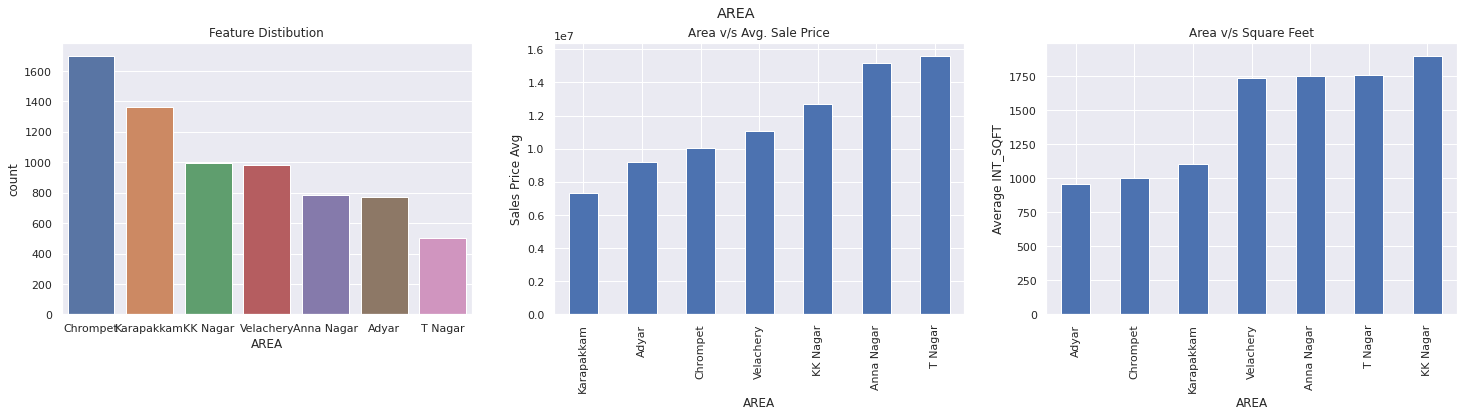

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle('AREA')

axes[0].set_title('Feature Distibution')
axes[1].set_title('Area v/s Avg. Sale Price')
axes[2].set_title('Area v/s Square Feet')

ax1=sns.countplot(x="AREA", data=df,order = df['AREA'].value_counts().index, ax=axes[0])#, palette="husl")
ax2=df.groupby("AREA")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax2.set_ylabel("Sales Price Avg")
ax=df.groupby("AREA")["INT_SQFT"].mean().sort_values(ascending=True).plot.bar()
ax.set_ylabel("Average INT_SQFT")




*   In the first graph we can see the count of sales in different AREA. 'Chrompet' has the highest no.of sale and 'T Nagar' has the lowest in the data.
*   Eventhough T-Nagar has the lowest no.of sales, the properties in T-Nagar have highest average sale price, this can be understood from the second graph. Average sales price is high for properties in Anna Nagar, T Nagar and KK Nagar, this maybe due to the fact that properties in this area have higher 'INT_SQFT' as seen in third graph. Second graph also showes that there is a linear relationship between Area and Average Sales Price and hence we can label encode them.
*   Third graph shows that properties in Velachery, Anna Nagar,T Nagar and KK Nagar have larger square feets (1600 - 1800 $ft^2$) thanproperties in Adyar,Chrompet and Karapakkam (900 - 1200 $ft^2$)





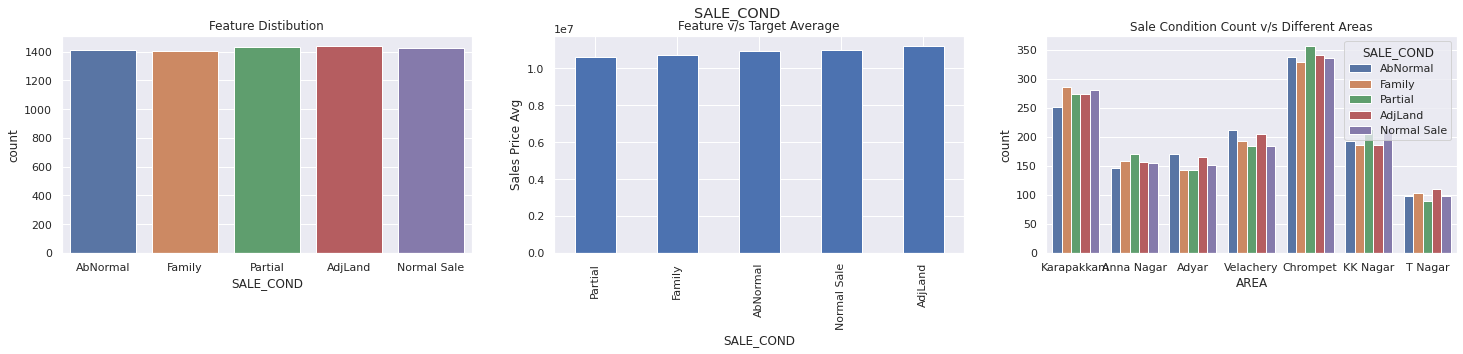

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('SALE_COND')

axes[0].set_title('Feature Distibution')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('Sale Condition Count v/s Different Areas')


sns.countplot(x="SALE_COND", data=df,ax=axes[0])
ax1=df.groupby("SALE_COND")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax1.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='SALE_COND',ax=axes[2])




*   In the second graph we can see a linear relation ship between Sale Condition and Average Sale Price. Hence we can do Label Encoding for this feature also
*   In the third graph we can see that irrespective of the area/locality the distribution of sale condition remains almost the same.



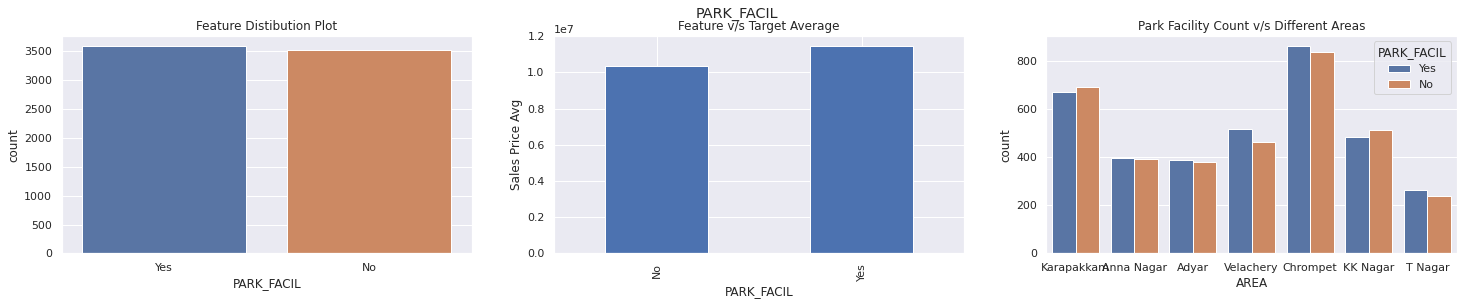

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('PARK_FACIL')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('Park Facility Count v/s Different Areas')


sns.countplot(x="PARK_FACIL", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("PARK_FACIL")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='PARK_FACIL',ax=axes[2])



*   In the second graph we can see that the Average Sale Price is higher for properties with Parking facility. And since it is a binary categorical variable we can label encode it.
*   Third graph shows that distribution of Parking facility is almost same irrespective of area.



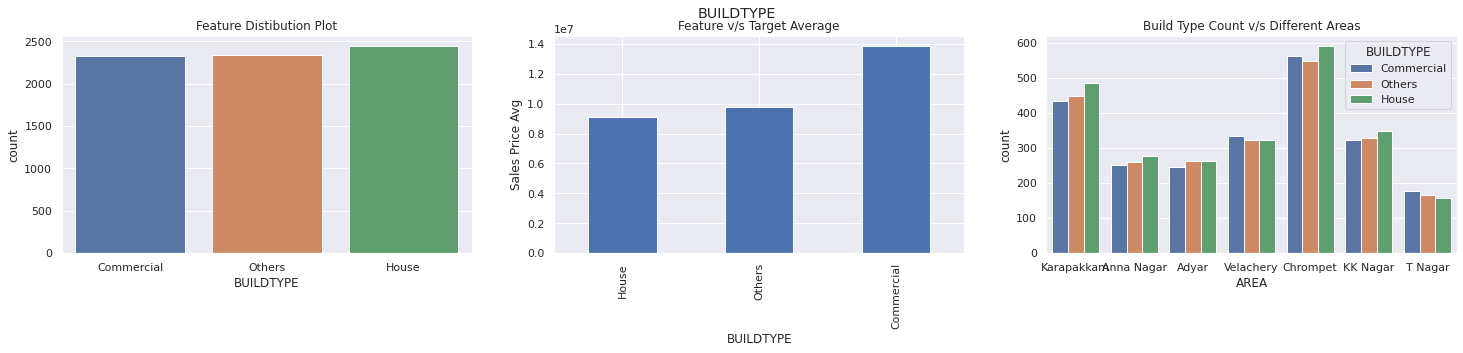

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('BUILDTYPE')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('Build Type Count v/s Different Areas')


sns.countplot(x="BUILDTYPE", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("BUILDTYPE")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='BUILDTYPE',ax=axes[2])




*   In the second graph we can see that there is a realtion between Build Type and Average Sales Price. However the relation does not seem to be linear, hence we will do one-hot encoding for Build Type.




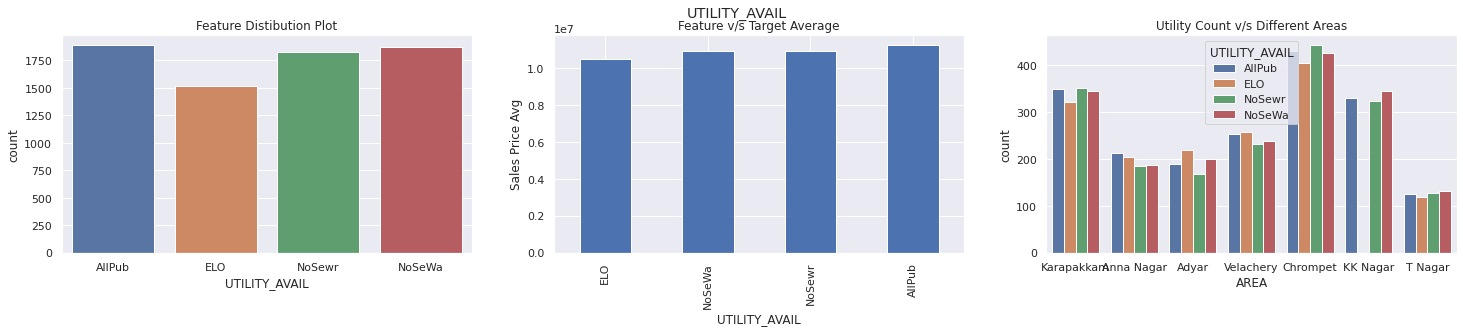

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('UTILITY_AVAIL')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('Utility Count v/s Different Areas')


sns.countplot(x="UTILITY_AVAIL", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("UTILITY_AVAIL")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='UTILITY_AVAIL',ax=axes[2])




*   In the second graph we can see that there is a linear realtion between Utility Available and Average Sales Price, hence we can label encode the feature.




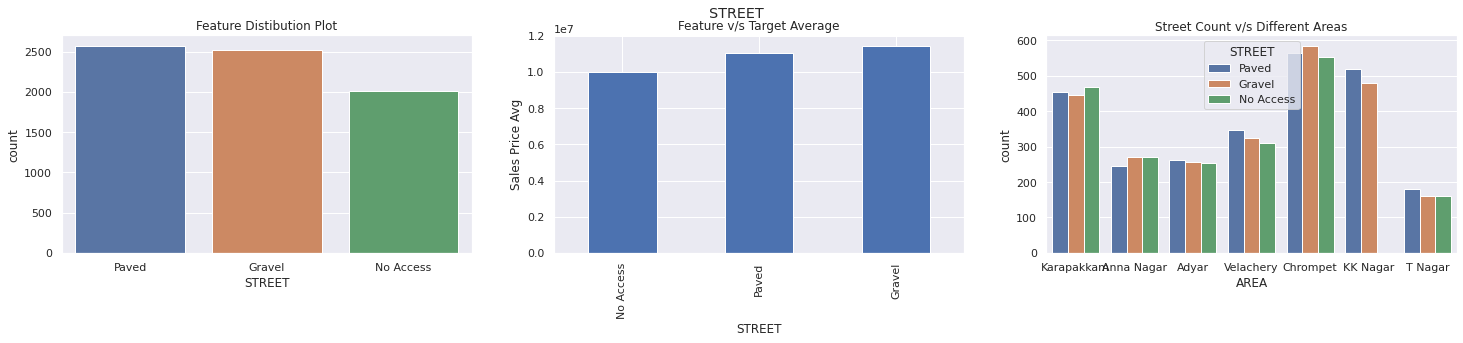

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('STREET')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('Street Count v/s Different Areas')


sns.countplot(x="STREET", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("STREET")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='STREET',ax=axes[2])


*   In the second graph we can see that there is a linear realtion between Street and Average Sales Price, hence we can label encode the feature.
*   The third graph shows that KK Nagar Areas have almost no properties without access.

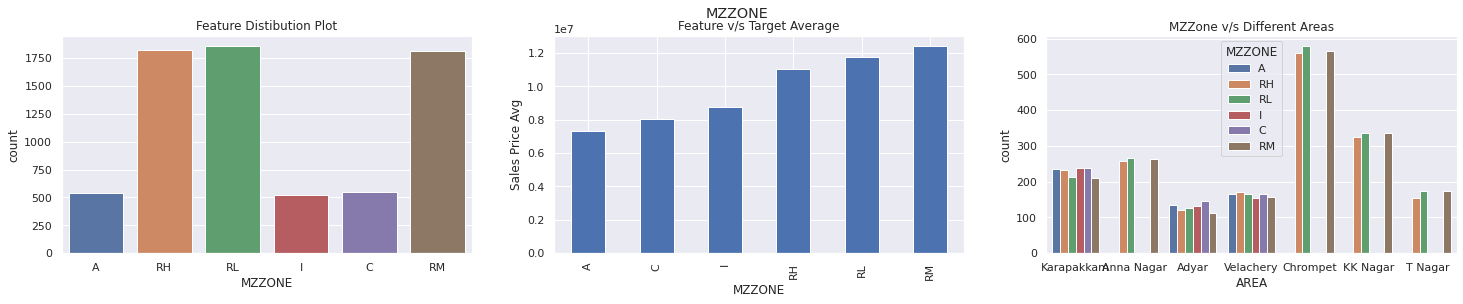

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,4))
fig.suptitle('MZZONE')

axes[0].set_title('Feature Distibution Plot')
axes[1].set_title('Feature v/s Target Average')
axes[2].set_title('MZZone v/s Different Areas')


sns.countplot(x="MZZONE", data=df,ax=axes[0])#, palette="husl")
ax=df.groupby("MZZONE")["SALES_PRICE"].mean().sort_values(ascending=True).plot.bar(ax=axes[1])
ax.set_ylabel("Sales Price Avg")
sns.countplot(x="AREA", data=df,hue='MZZONE',ax=axes[2])#, palette="husl")


*   Here from the first graph we can clearly observe that the no.of sales in residential zones are significantly greater than the sales of Agricultural,Industrial and Commercial zones.
*   From the second graph we can clearly understand that there is a linear relationship between MZZONE and the SALES PRICE.
*   From the third graph we can see that Anna Nagar, Chrompet, KK Nagar, T Nagar areas only contain residential properties (almost equal distribution between RL,RM,RH properties)





#### Multicollinearity Checking

Text(0.5, 1.0, 'Correlation of Features')

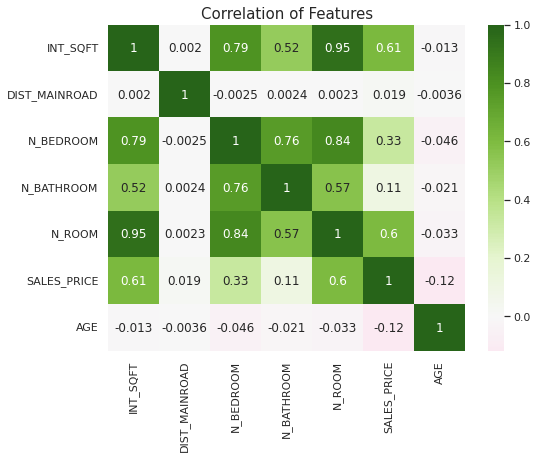

In [31]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df.corr(),
            annot=True,
            cbar=True,
            center=0,
            cmap="PiYG")
plt.title("Correlation of Features", fontsize=15)



*   From this correlation heat map we can see that **N_ROOMS** has high correlation between **INT_SQFT** and **N_BEDROOM**

*   To avoid Multicollinearity we can drop **N_ROOMS**



In [32]:
df.drop('N_ROOM',axis=1,inplace=True)

### Encoding

In [33]:
df2=df.copy()

In [34]:
df2["STREET"] = df2["STREET"].replace({"No Access" : 0,"Paved":1,"Gravel":2})

df2["SALE_COND"] = df2["SALE_COND"].replace({"Partial" : 0,"Family":1,"AbNormal":2,"Normal Sale":3,"AdjLand":4})

df2["AREA"] = df2["AREA"].replace({"Karapakkam" : 0,"Adyar":1,"Chrompet":2,"Velachery":3,"KK Nagar":4,"Anna Nagar":5,"T Nagar":6})

df2["PARK_FACIL"] = df2["PARK_FACIL"].replace({"No" : 0,"Yes":1})

df2["UTILITY_AVAIL"] = df2["UTILITY_AVAIL"].replace({"ELO" : 0,"NoSeWa":1,"NoSewr":2,"AllPub":3})

df2["MZZONE"] = df2["MZZONE"].replace({"A" : 0,"C":1,"I":2,"RH":3,"RL":4,"RM":5})

For the categorical features which we didn't label encode because of uncertainity of linear relationship with target, we get dummy variables.

In [35]:
 df2 = pd.get_dummies(df2)

# Model Fitting

Defining Features and Target

In [36]:
target="SALES_PRICE"
X = df2.drop(target,axis=1) 
y = df2[target]

Splitting Data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Linear Reg

In [ ]:
model = LinearRegression() 
model.fit(X_train,y_train) 

LinearRegression()

###Decision Tree Regressor

In [ ]:
for depth in [2,3,5,6,7,8,9,10,11,12,13,14,15,17,20]:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train) #train the model
    #model.score(X_test, y_test) # scoring the model - r2 squared
    print("Tree Depth : ", depth, " Train score : ", model.score(X_train,y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train, y_train, cv=10)))


Tree Depth :  2  Train score :  0.5095441880474871  Cross-Val score :  0.5074639032998772
Tree Depth :  3  Train score :  0.6919618541810978  Cross-Val score :  0.6882239549608358
Tree Depth :  5  Train score :  0.9045449265278732  Cross-Val score :  0.8972928243675551
Tree Depth :  6  Train score :  0.9323496629561341  Cross-Val score :  0.9222500450469303
Tree Depth :  7  Train score :  0.9535916201121308  Cross-Val score :  0.9408668626694734
Tree Depth :  8  Train score :  0.9682887832135092  Cross-Val score :  0.9532456038456665
Tree Depth :  9  Train score :  0.9798294155791213  Cross-Val score :  0.9606475470790226
Tree Depth :  10  Train score :  0.9880504558361393  Cross-Val score :  0.9650210803261008
Tree Depth :  11  Train score :  0.9936475237394031  Cross-Val score :  0.9682140032061042
Tree Depth :  12  Train score :  0.9968467006661489  Cross-Val score :  0.9688770534912179
Tree Depth :  13  Train score :  0.9984716110987963  Cross-Val score :  0.969024477645654
Tree De

In [ ]:
model = DecisionTreeRegressor(max_depth=13)
model.fit(X_train,y_train) 

DecisionTreeRegressor(max_depth=13)

### Random Forest


In [ ]:
for depth in [2,3,5,7,9,10,15,20]:
    model = RandomForestRegressor(n_estimators= 100, max_depth = depth, max_features='sqrt')
    model.fit(X_train,y_train) #train the model
    model.score(X_test, y_test) # scoring the model - r2 squared
    print("Tree Depth : ", depth, " Train score : ", model.score(X_train,y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train, y_train, cv=10)))

Tree Depth :  2  Train score :  0.5327932541485809  Cross-Val score :  0.5315571369933194
Tree Depth :  3  Train score :  0.6595160399213142  Cross-Val score :  0.653987310887224
Tree Depth :  5  Train score :  0.8276393005661096  Cross-Val score :  0.8229498082177823
Tree Depth :  7  Train score :  0.9250464291278491  Cross-Val score :  0.913775495172154
Tree Depth :  9  Train score :  0.9628464445298669  Cross-Val score :  0.9543087236406104
Tree Depth :  10  Train score :  0.9795011496833615  Cross-Val score :  0.9643764626324327
Tree Depth :  15  Train score :  0.9964750265272195  Cross-Val score :  0.9794469075888589
Tree Depth :  20  Train score :  0.9970255795036115  Cross-Val score :  0.9796997274813786


In [ ]:
model = RandomForestRegressor(n_estimators= 100, max_depth = 20, max_features='sqrt')
model.fit(X_train,y_train) 

RandomForestRegressor(max_depth=3, max_features='sqrt')

### XG Boost

In [38]:
for lr in [0.06,0.07,0.08,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.1]:
    model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
    model.fit(X_train,y_train) #train the model
    tr=model.score(X_test, y_test) # scoring the model - r2 squared
    xg =xgb.XGBRegressor(learning_rate = lr, n_estimators=100, verbosity = 0)
    valAccuracy = cross_val_score(xg, X_train, y_train, cv=10)
    print("Learning rate : ", lr, " Train score : ", tr, " Cross-Val score : ", np.mean(valAccuracy))

Learning rate :  0.06  Train score :  0.9789949251726221  Cross-Val score :  0.9779154512048365
Learning rate :  0.07  Train score :  0.9831064249102366  Cross-Val score :  0.9822752514028548
Learning rate :  0.08  Train score :  0.9864355908006491  Cross-Val score :  0.9858536975459369
Learning rate :  0.1  Train score :  0.9908171779758602  Cross-Val score :  0.9903261902231222
Learning rate :  0.2  Train score :  0.9962548283725016  Cross-Val score :  0.9956024687585678
Learning rate :  0.3  Train score :  0.9964293030340912  Cross-Val score :  0.9962617768750326
Learning rate :  0.4  Train score :  0.9959211195686034  Cross-Val score :  0.9958865308459306
Learning rate :  0.45  Train score :  0.995902414907233  Cross-Val score :  0.9958686456815726
Learning rate :  0.5  Train score :  0.9966207978535707  Cross-Val score :  0.9960843672230926
Learning rate :  0.55  Train score :  0.9969930733445755  Cross-Val score :  0.9960267932248585
Learning rate :  0.6  Train score :  0.9961958

In [39]:
model = xgb.XGBRegressor(learning_rate = 0.45, n_estimators=100)
model.fit(X_train,y_train) #train the model
#model.score(X_test, y_test) # scoring the model - r2 squared

[04:50:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.45)

# Prediction

In [40]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Evaluation

In [41]:
print('Train R2-SCORE:', metrics.r2_score(y_train,y_train_pred))
print('Test R2-SCORE:', metrics.r2_score(y_test,y_test_pred))


Train R2-SCORE: 0.9970283092310629
Test R2-SCORE: 0.995902414907233


# Feature Importance

Since the XG Boost model with learning rate of 0.4 has highset test accuracy, we will use it to calculate topr 4 important features.

In [42]:
model = xgb.XGBRegressor(learning_rate = 0.45, n_estimators=100)
model.fit(X_train,y_train) 
importance = model.feature_importances_
sorted(list(zip(importance,X_test.columns)),reverse=True)[:3]

[04:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[(0.37137946, 'BUILDTYPE_Commercial'),
 (0.28436622, 'AREA'),
 (0.066417955, 'BUILDTYPE_House')]

So here the top 3 features that affect the sale price of the property are **'AREA', 'BUILD_TYPE'** and **'INT_SQFT'** respectively.

# Prediction Interval

Here the prediction interval for the sale of a property is calculated using a cofidence interval of 0.95

In [43]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    #print(z_score)
    #generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    #return lower, prediction, upper
    print("Predicted Price : {:.2f}\nNegotiable Range :{:.2f} to {:.2f}".format(prediction,lower,upper))

get_prediction_interval(y_test_pred[0], y_test,y_test_pred) #Here instead of y_test_pred[0], you can give the features of required property.


Predicted Price : 13201734.00
Negotiable Range :12725431.49 to 13678036.51


# Inferences



* Commercial Properties fetch more revenue than any other BUILDTYPE properties.   
*  The no.of Sales in Chrompet Area is very high suggesting a better market potential there.
*  Based on Area, Sales Price is highest in T Nagar followed by Anna Nagar.   



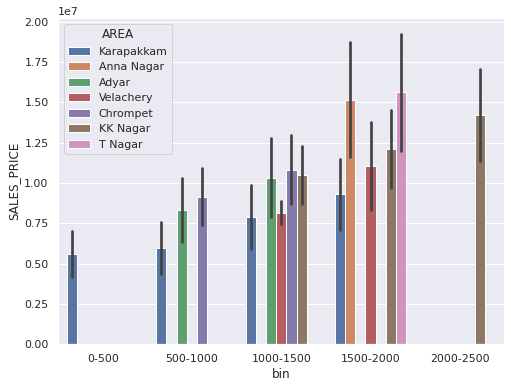

In [64]:
df3=df.copy()
df3['bin'] = pd.cut(df3['INT_SQFT'], bins=range(0,3000,500), labels=[f'{l}-{l+500}' for l in range(0,2500,500)])
sns.barplot(x='bin', y='SALES_PRICE', data=df3, hue='AREA',ci='sd')


This graph shows the Average Sales Price for Properties with different 'INT_SQFT' values in different area. Inference from this graph are :


*   T Nagar and Anna Nagar Properties yield maximum revenue and the properties in this Locality have 'INT_SQFT' (Property area in square-feet) in the the range 1500-2500  
*   Properties with INT_SQFT greater than 2000 are located only in KK Nagar.
*Properties with INT_SQFT less than 500 are located only in Karapakkam.
*   Properties with INT_SQFT in the range 1000-1500 have higher average sales price in Chrompet than properties with 1500-2000 INT_SQFT range in Karapakkam. So if you are planning to build a property, one with INT_SQFT between 1000 to 1500 in Chrompet, KK Nagar and Adyar will yield you more profit while selling than a property with INT_SQFT between 1500 to 2000 in Karapakkam (The no.of sales in Chrompet is very high as shown in EDA indicating a very dynamic market).



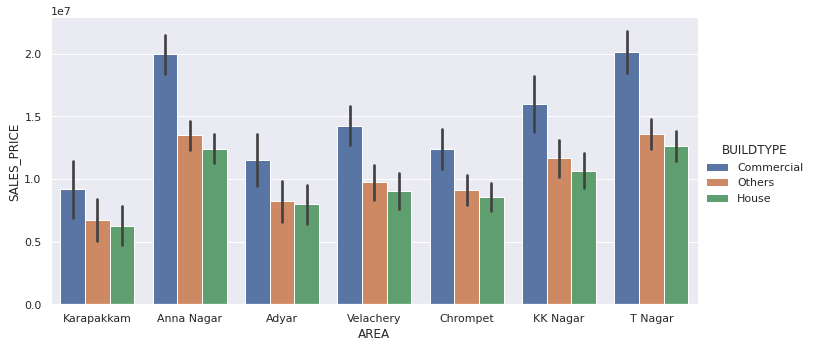

In [58]:
sns.catplot(
    data=df3, kind="bar",
    x="AREA", y="SALES_PRICE", hue="BUILDTYPE",
    ci="sd", height=5, aspect=2
)



*   Commercial Buildings fetch hisgest revenue based on the AREA in the order:

    **T Nagar > Anna Nagar > KK Nagar > Velachery > Chrompet > Karapakkam**




